<a href="https://colab.research.google.com/github/IHK-hk/Project/blob/main/Eng_%3EFrench_LanguageTranslator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Language Translator Using Basic ML | AI | DS (English to French)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load dataset
def load_data(path, num_samples=10000):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    sentence_pairs = [line.split('\t')[:2] for line in lines[:num_samples] if '\t' in line]
    return zip(*sentence_pairs)

eng_sentences, fr_sentences = load_data('/fra.txt')

# Add <start> and <end> tokens
fr_sentences = ['<start> ' + sent + ' <end>' for sent in fr_sentences]

# Step 2: Tokenize
def tokenize(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    tensor = tokenizer.texts_to_sequences(sentences)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

input_tensor, inp_tokenizer = tokenize(eng_sentences)
target_tensor, targ_tokenizer = tokenize(fr_sentences)

max_length_inp = input_tensor.shape[1]
max_length_targ = target_tensor.shape[1]
vocab_inp_size = len(inp_tokenizer.word_index) + 1
vocab_tar_size = len(targ_tokenizer.word_index) + 1

# Step 3: Build training model
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
enc_emb = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(enc_emb)

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb_layer = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = tf.keras.layers.Dense(vocab_tar_size, activation='softmax')
output = decoder_dense(decoder_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Step 4: Train the model
decoder_target = np.zeros_like(target_tensor)
decoder_target[:, :-1] = target_tensor[:, 1:]

model.fit([input_tensor, target_tensor], decoder_target,
          batch_size=64, epochs=10, validation_split=0.2)

# Step 5: Build inference models
# Encoder inference model
encoder_model = tf.keras.Model(encoder_inputs, [state_h, state_c])

# Decoder inference model
decoder_state_input_h = tf.keras.Input(shape=(units,))
decoder_state_input_c = tf.keras.Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Step 6: Define functions for translation
def preprocess_sentence(sentence):
    return sentence.lower().strip()

def tokenize_input(sentence):
    sequence = inp_tokenizer.texts_to_sequences([sentence])
    return pad_sequences(sequence, maxlen=max_length_inp, padding='post')

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = targ_tokenizer.word_index['<start>']

    decoded_sentence = ''
    for _ in range(max_length_targ):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = targ_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>':
            break
        decoded_sentence += ' ' + sampled_word

        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# Step 7: Take input from user and translate
while True:
    user_input = input("\nEnter an English sentence (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    user_input = preprocess_sentence(user_input)
    input_seq = tokenize_input(user_input)
    translated_sentence = decode_sequence(input_seq)
    print("Translated French sentence:", translated_sentence)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - loss: 3.5402 - val_loss: 1.9554
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 1.5977 - val_loss: 1.7725
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - loss: 1.3764 - val_loss: 1.6825
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - loss: 1.2147 - val_loss: 1.6130
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - loss: 1.0882 - val_loss: 1.5832
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - loss: 0.9611 - val_loss: 1.5715
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - loss: 0.8588 - val_loss: 1.5681
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - loss: 0.7767 - val_loss: 1.5748
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - loss: 0.7044 - val_loss: 1.5844
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - loss: 0.6254 - val_loss: 1.5939

Enter an English sentence (or 'exit' to quit): I like this place.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [3]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Load a small test set (e.g., 100 examples)
num_eval = 100
test_eng_sentences = list(eng_sentences)[:num_eval]
test_fr_sentences = list(fr_sentences)[:num_eval]

bleu_scores = []

for i in range(num_eval):
    input_text = preprocess_sentence(test_eng_sentences[i])
    input_seq = tokenize_input(input_text)
    predicted = decode_sequence(input_seq)

    # Reference sentence (excluding <start> and <end>)
    reference = test_fr_sentences[i].replace('<start>', '').replace('<end>', '').strip().split()
    candidate = predicted.strip().split()

    # BLEU score (with smoothing)
    score = sentence_bleu([reference], candidate,
                          weights=(0.5, 0.5),  # BLEU-2
                          smoothing_function=SmoothingFunction().method1)
    bleu_scores.append(score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

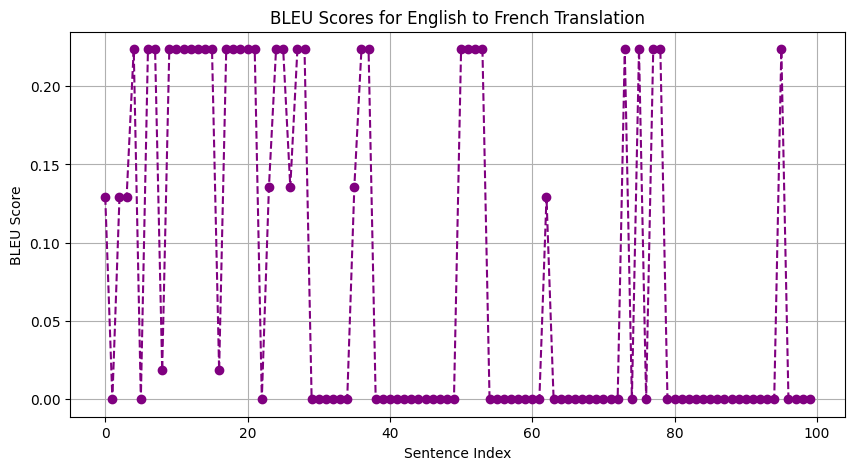


Average BLEU Score on 100 samples: 0.0767


In [5]:
# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', linestyle='--', color='purple')
plt.title("BLEU Scores for English to French Translation")
plt.xlabel("Sentence Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()

# Optional: Display average BLEU score
average_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU Score on {num_eval} samples: {average_bleu:.4f}")


In [6]:
# Show a few random samples
import random
for i in random.sample(range(num_eval), 5):
    print(f"\n🟦 English: {test_eng_sentences[i]}")
    print(f"🟨 Expected French: {test_fr_sentences[i].replace('<start>', '').replace('<end>', '').strip()}")
    input_seq = tokenize_input(preprocess_sentence(test_eng_sentences[i]))
    print(f"🟪 Predicted French: {decode_sequence(input_seq)}")



🟦 English: Relax.
🟨 Expected French: Relaxe !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🟪 Predicted French: du calme.

🟦 English: Sorry?
🟨 Expected French: Pardon ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🟪 Predicted French: pardon ?

🟦 English: Run.
🟨 Expected French: Prenez vos jambes à vos cous !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
🟪 Predicted French: cours !

🟦 English: Run!
🟨 Expected French: Filez !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🟪 Predicted French: cours !

🟦 English: Stop!
🟨 Expected French: Ça suffit !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━